In [79]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [80]:
def wrangle(csv_file):

    #read file
    df = pd.read_csv(csv_file)
    
    #leaky columns
    cols_to_drop = []

    #recast target
    df['Transported'] = df['Transported'].astype(int)

    #identify multicollinearity

    
    #high cardinality features   
    cols_to_drop.extend(['PassengerId', 'Name', 'Cabin'])
    
    

    #drop columns
    df.drop(columns=cols_to_drop, inplace=True)

    return df

In [81]:
#read csv and check first rows
df = wrangle('train.csv')
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [82]:
#get information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 747.2+ KB


In [83]:
cat = df.select_dtypes('object').columns

print(df[cat].nunique())
print("*****************")

HomePlanet     3
CryoSleep      2
Destination    3
VIP            2
dtype: int64
*****************


In [84]:
df['Transported'].astype(int).head()

0    0
1    1
2    0
3    0
4    1
Name: Transported, dtype: int64

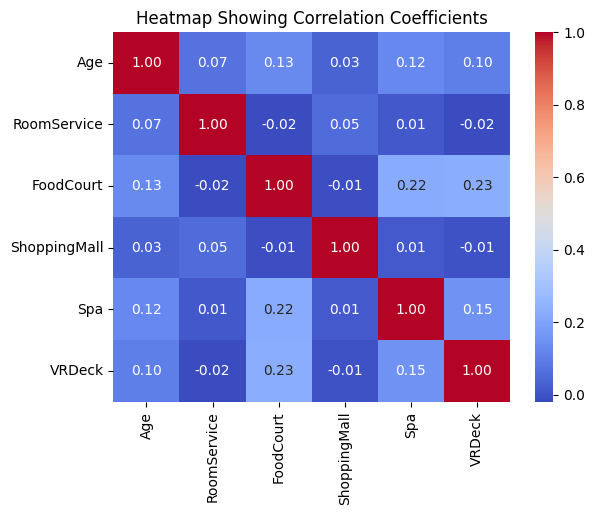

In [85]:
#get correlation of numerical features
num_corr = df.select_dtypes('float').corr()
sns.heatmap(num_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Showing Correlation Coefficients');


In [86]:
#describe
num_feat = df.select_dtypes('float').describe()
num_feat

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


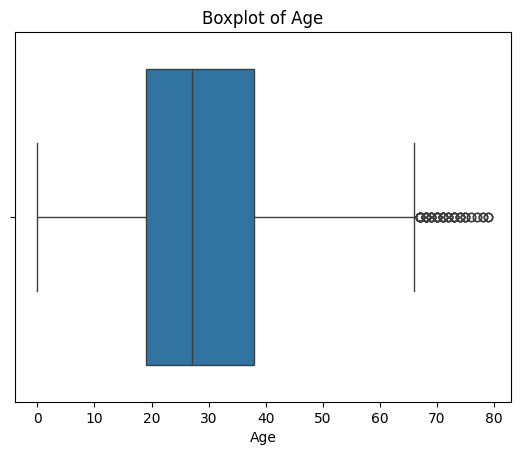

888888888888888


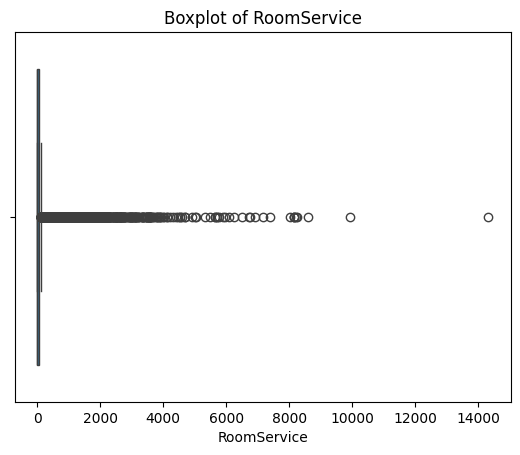

888888888888888


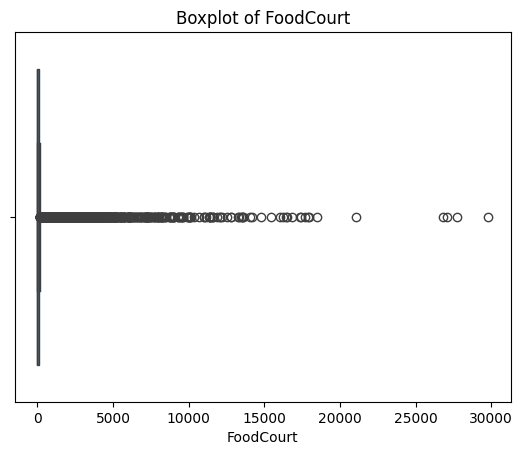

888888888888888


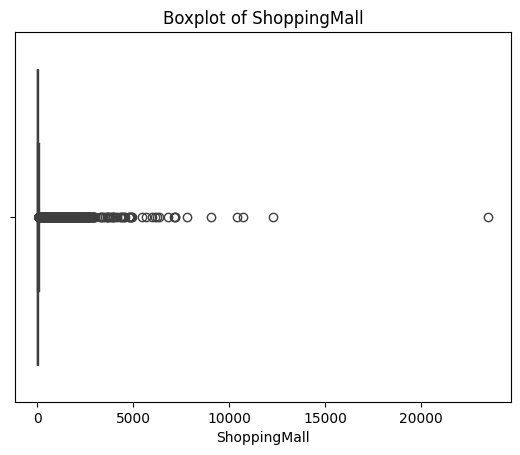

888888888888888


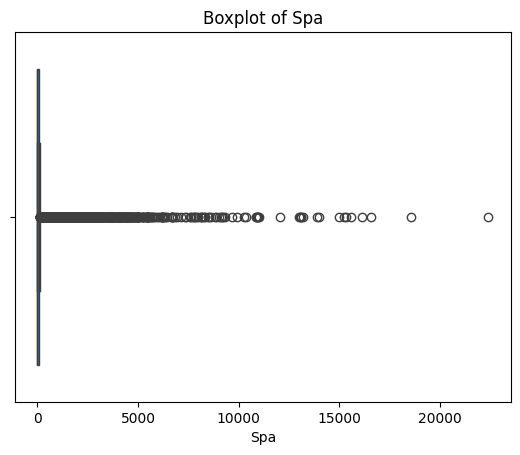

888888888888888


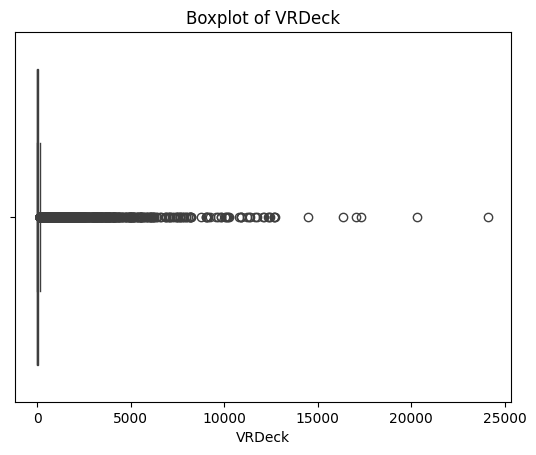

888888888888888


In [87]:
#plot boxplots
for col in num_feat.columns:
    col_plot = df[col]
    sns.boxplot(col_plot, orient='h')
    plt.title(f'Boxplot of {col}')
    plt.show()
    print('888888888888888')

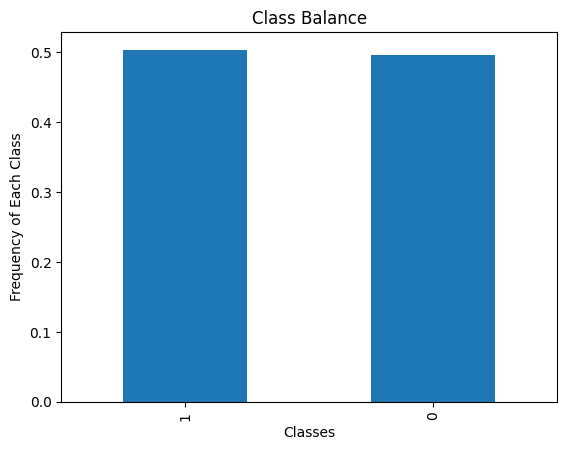

In [88]:
#check class balance
df['Transported'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Frequency of Each Class')
plt.title('Class Balance');

In [89]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [90]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1


In [91]:
print(df.columns)

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported'],
      dtype='object')


In [92]:
#get features and target
target = 'Transported'
X = df.drop(columns=target)
y = df[target]
print('DF Shape', df.shape)
print('X shape',X.shape)
print('Y', y.shape)

DF Shape (8693, 11)
X shape (8693, 10)
Y (8693,)


In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)


X_train (6954, 10)
X_test (1739, 10)
y_train (6954,)
y_test (1739,)


In [94]:
cat_feat = X.select_dtypes('float').columns
num_feat = X.select_dtypes('float').columns


In [95]:
baseline_score = y.value_counts(normalize=True).max()
print('Baseline accuracy:', baseline_score)


Baseline accuracy: 0.5036236051995858


In [96]:
#compare scores
model_names = []
final_train_acc = []
final_test_acc = []
final_cv = []

In [97]:
print(final_test_acc)

[]


In [98]:
#preprocessing
preprocessor =  ColumnTransformer([
    ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), cat_feat),
    ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), num_feat)
])


In [99]:
#make pipeline
model_log = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000)
)

#model name from pipeline
model_log_name = model_log.steps[-1][0]
model_names.append(model_log_name)

#fit model
model_log.fit(X_train, y_train)

#train model
y_pred_train_log = model_log.predict(X_train)

#train accuracy
acc_train_log = accuracy_score(y_train, y_pred_train_log)
final_train_acc.append(acc_train_log)

#predict on test set
y_pred_test_log = model_log.predict(X_test)

#test accuracy
acc_test_log = accuracy_score(y_test, y_pred_test_log)
final_test_acc.append(acc_test_log)

#cross validation
cv_scores_log = cross_val_score(model_log, X, y, cv=5, scoring='accuracy')
final_cv.append(round(cv_scores_log.mean(),2))

In [100]:
#make pipeline for decision tree
model_tr = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth= 5, random_state=42)
)

#model name from pipeline
model_tr_name = model_tr.steps[-1][0]
model_names.append(model_tr_name)

#fit model
model_tr.fit(X_train, y_train)

#train model
y_pred_train_tr = model_tr.predict(X_train)

#train accuracy
acc_train_tr = accuracy_score(y_train, y_pred_train_tr)
final_train_acc.append(acc_train_tr)

#predict on test set
y_pred_test_tr = model_tr.predict(X_test)

#test accuracy
acc_test_tr = accuracy_score(y_test, y_pred_test_tr)
final_test_acc.append(acc_test_tr)

#cross validation
cv_scores_tr = cross_val_score(model_tr, X, y, cv=5, scoring='accuracy')
final_cv.append(round(cv_scores_tr.mean(),2))

In [101]:
#tree depth
depth = model_tr.named_steps['decisiontreeclassifier'].get_depth()
depth

5

In [102]:

#store acc scores
depths = []
training_accuracy = []
test_accuracy = []
gaps = []

#tune model
params = range(1, 101, 2)
for d in params:
    depths.append(d)
    model_tr = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth= d, random_state=42)
    )

    #fit model
    model_tr.fit(X_train, y_train)

    #train model
    y_pred_train = model_tr.predict(X_train)

    #train accuracy
    acc_train = accuracy_score(y_train, y_pred_train)

    #append training score
    training_accuracy.append(acc_train)

    #predict on test set
    y_pred_test = model_tr.predict(X_test)

    #test accuracy
    acc_test = accuracy_score(y_test, y_pred_test)

    #append test scores
    test_accuracy.append(acc_test)

    #gap
    gap = (acc_train - acc_test)
    gaps.append(gap)



In [103]:
#store accuracy scores in df
accuracy_df = pd.DataFrame({
    'depths': depths,
    'train_acc': training_accuracy,
    'test_acc': test_accuracy,
    'gap': gaps
})
accuracy_df.head(10)

,depths,train_acc,test_acc,gap
0,1,0.667098,0.665325,0.001773
1,3,0.776531,0.764807,0.011724
2,5,0.793500,0.765957,0.027543
3,7,0.806442,0.765957,0.040485
4,9,0.828013,0.767683,0.060330
5,11,0.846563,0.767108,0.079456
6,13,0.863532,0.761932,0.101600
7,15,0.876330,0.755032,0.121299
8,17,0.882370,0.755607,0.126763
9,19,0.889704,0.751006,0.138697


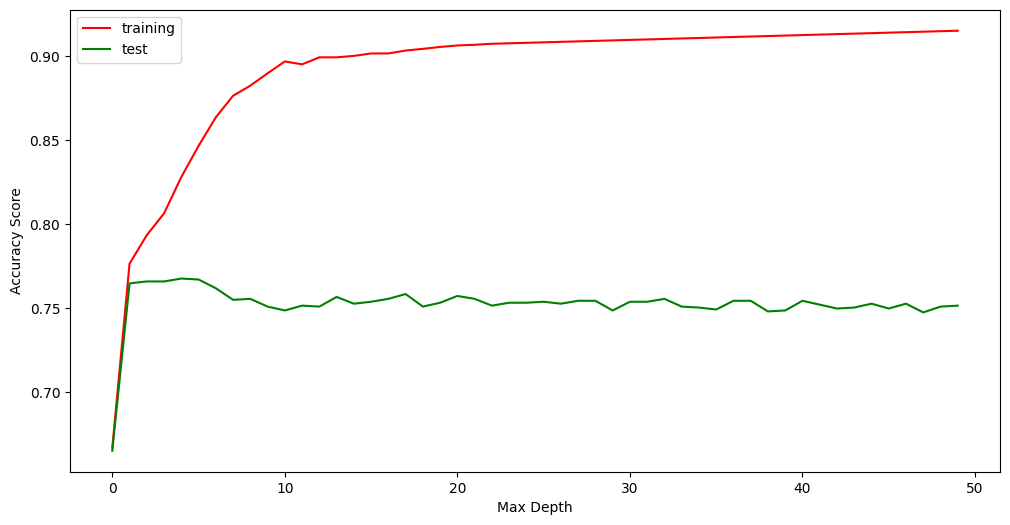

In [104]:
#plot accuracies
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(training_accuracy, color='red', label='training')
ax.plot(test_accuracy, color='green', label='test')
ax.set_xlabel('Max Depth')
ax.set_ylabel('Accuracy Score')
ax.legend()
plt.show();

In [105]:

#make pipeline random forest
model_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=60, n_estimators=100, random_state=42)
)

#model name from pipeline
model_rf_name = model_rf.steps[-1][0]
model_names.append(model_rf_name)


#fit model
model_rf.fit(X_train, y_train)


#train model
y_pred_train_rf = model_rf.predict(X_train)


#train accuracy
acc_train_rf = accuracy_score(y_train, y_pred_train_rf)
final_train_acc.append(acc_train_rf)


#predict on test set
y_pred_test_rf = model_rf.predict(X_test)


#test accuracy
acc_test_rf = accuracy_score(y_test, y_pred_test_rf)
final_test_acc.append(acc_test_rf)


#cross validation
cv_scores_rf = cross_val_score(model_rf, X, y, cv=5, scoring='accuracy')
final_cv.append(round(cv_scores_rf.mean(),2))

In [106]:
dept = [estimator.get_depth() for estimator in model_rf['randomforestclassifier'].estimators_]
max_dept = max(dept) 
ave_dept = sum(dept)/len(dept) 
print('Max depth:', max_dept)
print('Average depth:', ave_dept)

Max depth: 60
Average depth: 60.0


In [107]:
# Gradient Boosting pipeline
model_gb = make_pipeline(
    preprocessor,
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
)

# model name
model_gb_name = model_gb.steps[-1][0]
model_names.append(model_gb_name)

# fit model
model_gb.fit(X_train, y_train)

# train prediction
y_pred_train_gb = model_gb.predict(X_train)
acc_train_gb = accuracy_score(y_train, y_pred_train_gb)
final_train_acc.append(acc_train_gb)


# test prediction
y_pred_test_gb = model_gb.predict(X_test)
acc_test_gb = accuracy_score(y_test, y_pred_test_gb)
final_test_acc.append(acc_test_gb)

# cross-validation
cv_scores_gb = cross_val_score(model_gb, X, y, cv=5, scoring='accuracy')
final_cv.append(round(cv_scores_gb.mean(), 2))

In [108]:
#from sklearn.model_selection import GridSearchCV

# Pipeline
model_gb = make_pipeline(
    preprocessor,
    #GradientBoostingClassifier(random_state=42)
)

# Hyperparameter grid
param_grid = {
    'gradientboostingclassifier__n_estimators': [100, 150, 200],
    'gradientboostingclassifier__learning_rate': [0.01, 0.05, 0.1],
    'gradientboostingclassifier__max_depth': [3, 4, 5],
    'gradientboostingclassifier__subsample': [0.8, 1.0]
}

# Grid search
grid_search = GridSearchCV(
    model_gb,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
grid_search.fit(X_train, y_train)

# Best estimator
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", round(grid_search.best_score_, 3))
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

acc_train_best = accuracy_score(y_train, y_train_pred)
acc_test_best = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", round(acc_train_best, 3))
print("Test Accuracy:", round(acc_test_best, 3))

NameError: name 'GridSearchCV' is not defined

In [ ]:
#compare scores in dataframe

df_scores = pd.DataFrame({
    'model_name': model_names,
    'train accuracy':final_train_acc,
    'test accuracy': final_test_acc,
    'cv score': final_cv
})
df_scores.head()

,model_name,train accuracy,test accuracy,cv score
0,logisticregression,0.853897,0.782634,0.78
1,decisiontreeclassifier,0.793500,0.765957,0.77
2,randomforestclassifier,0.879350,0.761932,0.77
3,gradientboostingclassifier,0.807737,0.779758,0.79


In [ ]:
df_1 = pd.read_csv('test.csv')
df_1.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [118]:
df_2 = wrangle('train.csv')
df_2.shape

(8693, 11)

In [113]:
def wrangle_test(csv_file):

    #read file
    df = pd.read_csv(csv_file)
    
    #leaky columns
    cols_to_drop = []

    #recast target
    #df['Transported'] = df['Transported'].astype(int)

    #identify multicollinearity

    
    #high cardinality features   
    cols_to_drop.extend(['PassengerId', 'Name', 'Cabin'])
    
    

    #drop columns
    df.drop(columns=cols_to_drop, inplace=True)

    return df

In [115]:
test = wrangle_test('test.csv')
test.head()

(4277, 10)